In [62]:
# investigate the low clustering efficiency for 55 GeV
# mostly due to the fact that after met cut the deltaR of the two LLPs are < 0.4, resulting in two LLPs reconstructing to the same cluster
# but in general 55 GeV clusters have larger NStations
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [38]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()



isData = 0

ntupler_version = 'V1p17/'

analyzer_version = "/v1/v139/" #new acceptance definition

#     analyzer_version = "/v1/v110/" #new acceptance definition and no cuts at all


decay = '4Tau'
mass = [ '7', '15', '40','55']
ctaus  = ['100','1000','10000','100000']
# ctaus = ['10']
for ct in ctaus:
    for m in mass:
        mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
        fpath['m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
   



m7ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v139//normalized/ggH_HToSSTo4Tau_MH-125_MS-7_ctau-100_137000pb_weighted.root
m15ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v139//normalized/ggH_HToSSTo4Tau_MH-125_MS-15_ctau-100_137000pb_weighted.root
m40ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v139//normalized/ggH_HToSSTo4Tau_MH-125_MS-40_ctau-100_137000pb_weighted.root
m55ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v139//normalized/ggH_HToSSTo4Tau_MH-125_MS-55_ctau-100_137000pb_weighted.root
m7ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v139//normalized/ggH_HToSSTo4Tau_MH-125_MS-7_ctau-1000_137000pb_weighted.root
m15ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v139/

In [100]:

gLLP_dEta = {}
gLLP_deltaR = {}
nCscClusters = {}
nDtClusters = {}
cscCluster_match0 = {}
cscCluster_match1 = {}
dtCluster_match = {}
cscCluster_match_vertex0 = {}
cscCluster_match_vertex1 = {}
nStation = {}
weight = {}
sel_ev = {}
cluster_index = ''
for k, T in tree.items():
    if not k[-4:] == '1000':continue

    sel_csccluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread')<20)
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<0.75)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')<20)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<50)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster'+cluster_index+'_match_gLLP_minDeltaR') < 0.4)


    sel_dtcluster = T.array('dtRechitCluster_match_RPChits_dPhi0p5')>0
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 100)
    sel_dtcluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster'+cluster_index+'_match_gLLP_minDeltaR') < 0.4)

    
    
    sel_ev[k] = np.logical_and(T.array('metEENoise')>=200 ,T.array('METNoMuTrigger'))
    sel_ev[k] = np.logical_and(sel_ev[k], sel_csccluster.sum()==1)
    sel_ev[k] = np.logical_and(sel_ev[k], sel_csccluster.sum()==1)
    gLLP_deltaR[k] = T.array('gLLP_deltaR')
    gLLP_dEta[k] = T.array('gLLP_eta')[:,0]-T.array('gLLP_eta')[:,1]
    weight[k] = (T.array('weight')*T.array('higgsPtWeight'))
    
    nCscClusters[k] = sel_csccluster.sum()
    nDtClusters[k] = sel_dtcluster.sum()
    cscCluster_match0[k] = deltaR(T.array('cscRechitClusterEta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitClusterPhi')[sel_csccluster][sel_ev[k]][:,0], T.array('gLLP_eta')[sel_ev[k]][:,0], T.array('gLLP_phi')[sel_ev[k]][:,0])
    cscCluster_match1[k] = deltaR(T.array('cscRechitClusterEta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitClusterPhi')[sel_csccluster][sel_ev[k]][:,0], T.array('gLLP_eta')[sel_ev[k]][:,1], T.array('gLLP_phi')[sel_ev[k]][:,1])
    cscCluster_match_vertex0[k] = ((T.array('cscRechitClusterX')[sel_csccluster][sel_ev[k]][:,0]-T.array('gLLP_decay_vertex_x')[sel_ev[k]][:,0])**2\
                            + (T.array('cscRechitClusterY')[sel_csccluster][sel_ev[k]][:,0]-T.array('gLLP_decay_vertex_y')[sel_ev[k]][:,0])**2\
                            + (T.array('cscRechitClusterZ')[sel_csccluster][sel_ev[k]][:,0]-T.array('gLLP_decay_vertex_z')[sel_ev[k]][:,0])**2)**0.5
    cscCluster_match_vertex1[k] = ((T.array('cscRechitClusterX')[sel_csccluster][sel_ev[k]][:,0]-T.array('gLLP_decay_vertex_x')[sel_ev[k]][:,1])**2\
                            + (T.array('cscRechitClusterY')[sel_csccluster][sel_ev[k]][:,0]-T.array('gLLP_decay_vertex_y')[sel_ev[k]][:,1])**2\
                            + (T.array('cscRechitClusterZ')[sel_csccluster][sel_ev[k]][:,0]-T.array('gLLP_decay_vertex_z')[sel_ev[k]][:,1])**2)**0.5
    
    nStation[k] = T.array('cscRechitClusterNStation10')[sel_csccluster][sel_ev[k]][:,0]
    #     cscCluster_match_gLLP1[k] = deltaR(T.array('cscRechitClusterPhi'), T.array('gLLP_phi')[:,1])
#     cscCluster_match_gLLP0[k] = deltaR(T.array('dtRechitClusterPhi'), T.array('gLLP_phi')[:,0])
#     cscCluster_match_gLLP1[k] = deltaR(T.array('dtRechitClusterPhi'), T.array('gLLP_phi')[:,1])
#     dtCluster_match[k] = (T.array('dtRechitCluster'+cluster_index+'_match_gLLP_minDeltaR') < 0.4).sum()

    print(k)

m7ctau1000
m15ctau1000
m40ctau1000
m55ctau1000


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


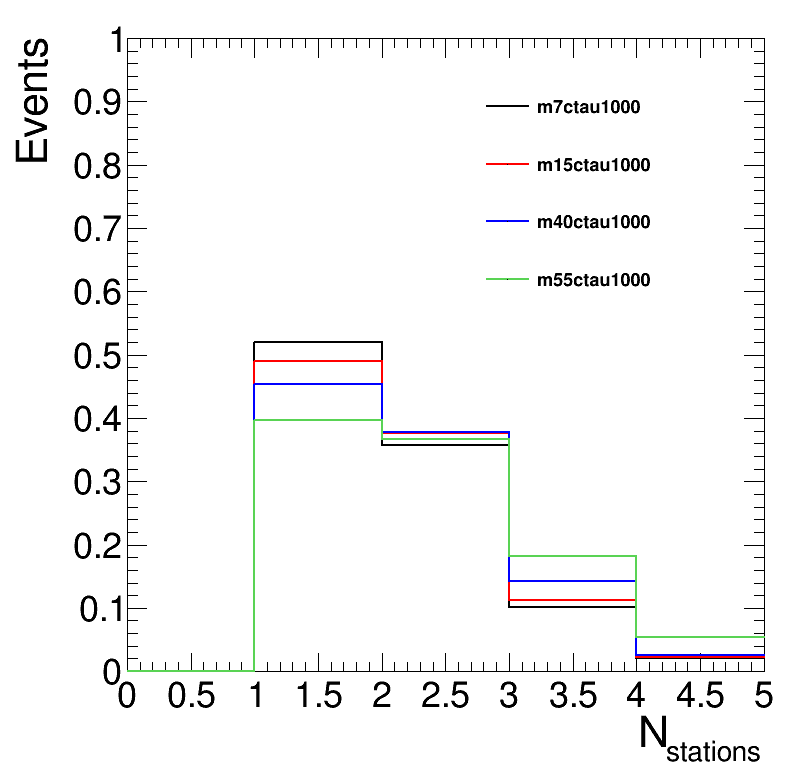

In [103]:
import os



met = True



leg = rt.TLegend(0.2,0.6,0.5,0.9)
leg = rt.TLegend(0.6,0.6,0.9,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)

rt.gStyle.SetOptFit(1011)
h = {}

for i, k in enumerate(gLLP_deltaR.keys()):
    if not k[-4:] == '1000':continue
# #     h[k] = create_TH1D(gLLP_deltaR[k],axis_title = ['#Delta R(LLP_{1}, LLP_{2})','Events'], binning=[30,0,5],weights = weight[k])
#     h[k] = create_TH1D(gLLP_deltaR[k][sel_ev[k]],axis_title = ['#Delta R(LLP_{1}, LLP_{2})','Events'], binning=[30,0,5],weights = weight[k][sel_ev[k]])
#     h[k] = create_TH1D(dtCluster_match[k][sel_ev[k]],axis_title = ['N_{matched LLPs}','Events'], binning=[4,1,5],weights = weight[k][sel_ev[k]])
#     h[k] = create_TH1D(cscCluster_match0[k],axis_title = ['N_{matched LLPs}','Events'], binning=[50,0,5],weights = weight[k][sel_ev[k]])
    h[k] = create_TH1D(nStation[k],axis_title = ['N_{stations}','Events'], binning=[5,0,5],weights = weight[k][sel_ev[k]])
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    leg.AddEntry(h[k],k)
    h[k].Draw('hist same')



leg.Draw()
c.SetTicky(1)
c.SetTickx(1)
#     if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
#     else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
#     if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+names[j]
#     print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
c.Draw()




# 2d matching

m7ctau1000 0.0013034410844629822
m15ctau1000 0.006277244986922406
m40ctau1000 0.07239882369416048
m55ctau1000 0.5616194043160335


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


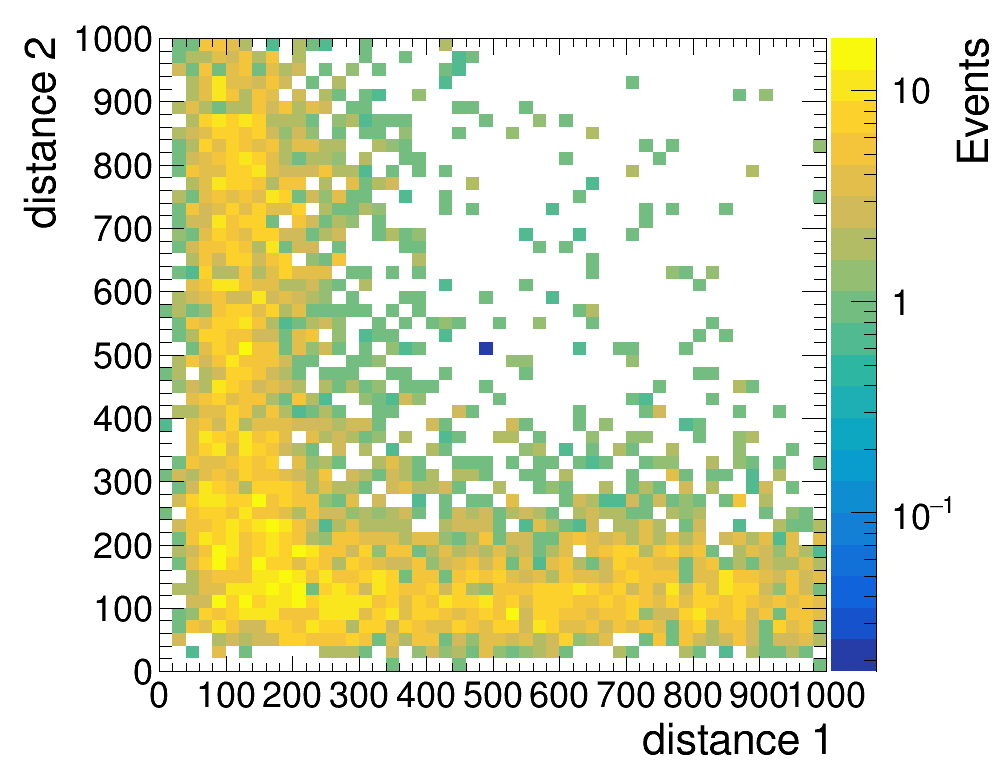

In [99]:
import os



met = True



leg = rt.TLegend(0.2,0.6,0.5,0.9)
leg = rt.TLegend(0.6,0.6,0.9,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 1000, 800)
c.SetRightMargin(0.04)

rt.gStyle.SetOptFit(1011)
h = {}

for i, k in enumerate(gLLP_deltaR.keys()):
    if not k[-4:] == '1000':continue
#     if not '7' in k:continue
#     h[k] = create_TH2D(np.column_stack((cscCluster_match0[k], cscCluster_match1[k])),axis_title = ['#Delta R1','#DeltaR2','Events'], binning=[50,0,1, 50,0,1],weights = weight[k][sel_ev[k]])
    h[k] = create_TH2D(np.column_stack((cscCluster_match_vertex0[k], cscCluster_match_vertex1[k])),axis_title = ['distance 1','distance 2','Events'], binning=[50,0,1000, 50,0,1000],weights = weight[k][sel_ev[k]])
    print(k, np.count_nonzero(np.logical_and(cscCluster_match0[k]<0.4, cscCluster_match1[k]<0.4))/len(cscCluster_match0[k]))
#     print(k, np.count_nonzero(np.logical_and(cscCluster_match_vertex0[k]<100, cscCluster_match_vertex1[k]<100))/len(cscCluster_match0[k]))
    #     h[k].SetLineColor(std_color_list[i])
#     h[k].Scale(1./h[k].Integral())
#     h[k].SetMaximum(1)
#     leg.AddEntry(h[k],k)
    h[k].Draw('colz')



c.SetTicky(1)
c.SetTickx(1)
c.SetRightMargin(0.17)
#     if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
#     else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
#     if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+names[j]
#     print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
c.SetLogz()
c.Draw()




[   100   1000  10000 100000] [0.00051871 0.00245022 0.0008714  0.00010995]
[   100   1000  10000 100000] [6.1465416e-04 1.6119396e-03 5.4284831e-04 6.6587017e-05]
[   100   1000  10000 100000] [2.8408962e-05 4.3636872e-04 2.3566145e-05 4.5320724e-07]
[   100   1000  10000 100000] [2.7982485e-06 2.0721632e-04 1.0815684e-05 2.7317640e-07]
[   100   1000  10000 100000] [2.4624309e-05 8.4504209e-05 3.6569836e-06 1.8003082e-07]
[   100   1000  10000 100000] [9.8640521e-07 1.4464819e-04 9.0934773e-06 0.0000000e+00]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


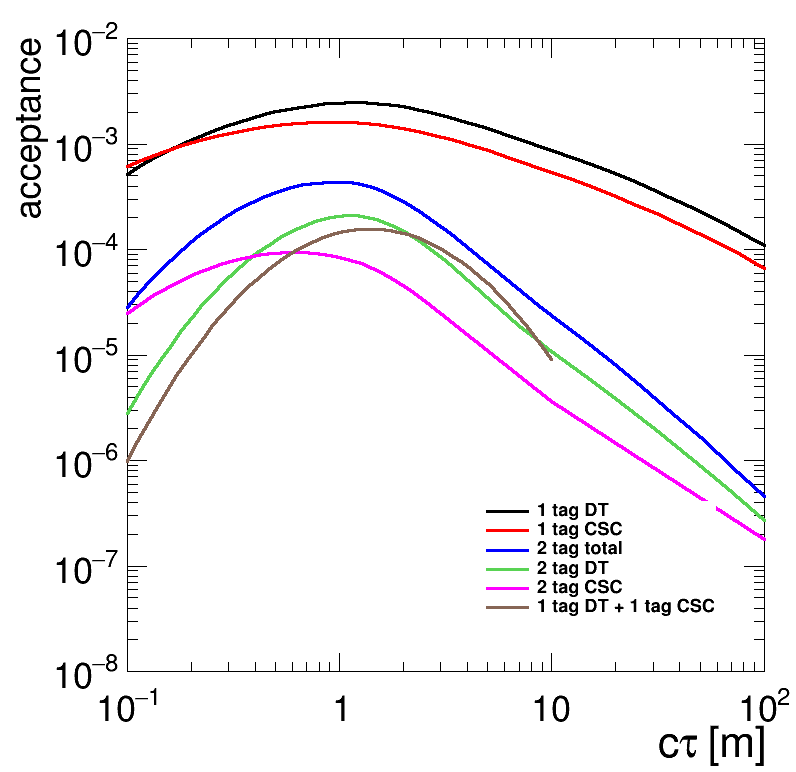

In [6]:
import os


met = 1


names = ['1 tag DT', '1 tag CSC', '2 tag total', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_2tag, accep_met_dt2, accep_met_csc2, accep_met_cross]
else: variables = [acceptance_dt1, acceptance_csc1, acceptance_2tag, acceptance_dt2, acceptance_csc2, acceptance_cross]
    
    

for j, m in enumerate(mass):
    
    if not m == '15':continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    for i, var in enumerate(variables):


        y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
        x = np.array([int(a) for a in ctaus])
        
        cond = y>0.0
        print(x, y)
        h[m+str(i)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'acceptance'])


        h[m+str(i)].SetLineColor(std_color_list[i])
        h[m+str(i)].SetLineWidth(3)
        h[m+str(i)].GetXaxis().SetTitleOffset(1)
        h[m+str(i)].GetYaxis().SetTitleSize(0.05)
        h[m+str(i)].GetYaxis().SetTitleOffset(1.5)
        h[m+str(i)].GetXaxis().SetLimits(0.1,100.0)
        if met:h[m+str(i)].GetYaxis().SetRangeUser(1e-8,0.01)
        else: h[m+str(i)].GetYaxis().SetRangeUser(1e-7,1)
        leg.AddEntry(h[m+str(i)], names[i], "L")


    for i,k in enumerate(h.keys()):
        h[k].Draw('CA' if i == 0 else 'Csame')

    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
#     if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
#     else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
#     if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+'mass'+m

#     if total:
#         c.SaveAs(name+'_all.png')
#         c.SaveAs(name+'_all.C')
#         c.SaveAs(name+'_all.pdf')
#     else:
#         c.SaveAs(name+'.png')
#         c.SaveAs(name+'.C')
#         c.SaveAs(name+'.pdf')

    c.Draw()






# hepdata plot for EXO-20-015

[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    

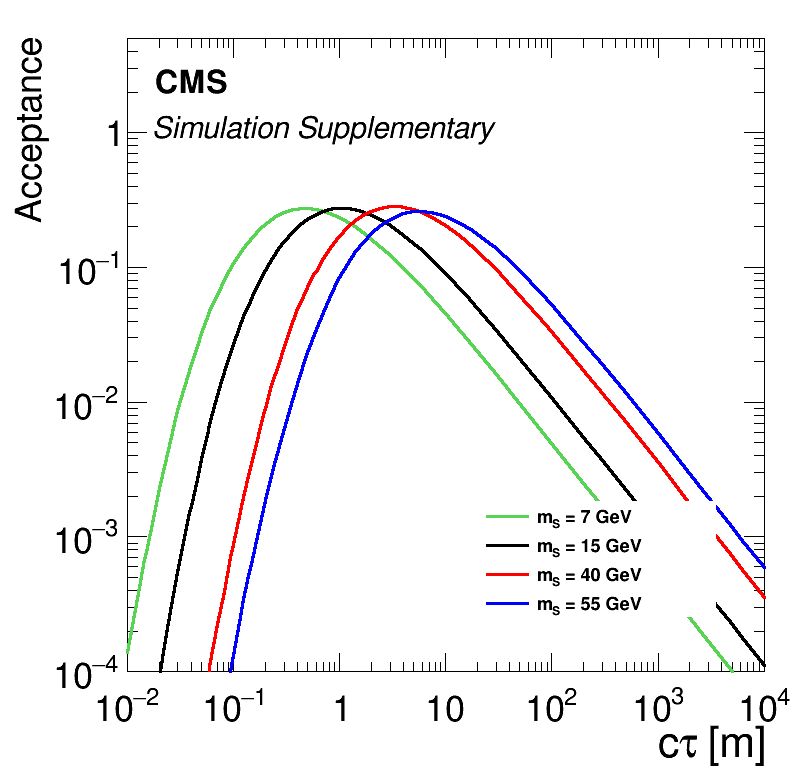

In [4]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
import math
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')

from helper import  weight_calc

importlib.reload(sys.modules['CMS_lumi'])


OLD_CTAU= [100,1000,10000,100000]



leg = rt.TLegend(0.6,0.2,0.9,0.35)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
h = {}

ctaus = ['5','10','15','20','30','40', '50','60', '100', '125','150','200','300','500','600','700','800','900','1000', '2000','3000','4000', '5000', '6000','7000','8000','10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000', '2000000', '3000000', '5000000', '6000000', '10000000'] #mm
acceptance = {}

for i, m in enumerate(mass):
    acceptance[m] = []
    #ctau reweighting
    for ct in ctaus:
        accep_temp = 0
        ctf = int(ct)
        ct_list = 10**int(math.log10(ctf))
        if ctf < OLD_CTAU[0]: ct_list = [OLD_CTAU[0]]
        elif ctf>OLD_CTAU[-1]: ct_list = [OLD_CTAU[-1]]
        elif ct_list == int(ct): ct_list = [int(ct)]
        else:ct_list = [ct_list,ct_list*10]
   
        
        for j, ct0 in enumerate(ct_list):
            k = 'm'+str(m)+'ctau'+str(ct0)
            T = tree[k]
            if np.count_nonzero(sel_ev_csc1[k])==0:continue
            gLLP_ctau = T.array('gLLP_ctau')[sel_ev_csc1[k]]
            weight_ctau = weight_calc(gLLP_ctau, int(ct)/10, int(ct0)/10) # convert everything to cm
            gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev_csc1[k]]
            if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
            else:
                if j == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
            weight = (T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc1[k]]
            w = (weight*weight_ctau)[weight_cond]
            accep_temp += np.sum(w)
        acceptance[m].append(accep_temp/6664892.0)
#         print(ct, m, acceptance[m][-1])
    
    #######################
    
#     y = np.array([acceptance_csc1['m'+m+'ctau100'], acceptance_csc1['m'+m+'ctau1000'], acceptance_csc1['m'+m+'ctau10000'], acceptance_csc1['m'+m+'ctau100000']])
    x = np.array([int(a) for a in ctaus])
    y = np.array(acceptance[m])
    cond = y>0.0
    print(x)
    h[m] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'Acceptance'])


    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])

    h[m].SetLineWidth(3)
    h[m].GetXaxis().SetTitleOffset(1)
    h[m].GetYaxis().SetTitleSize(0.05)
    h[m].GetYaxis().SetTitleOffset(1.5)
    h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-4,5)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    
    ###### save to text file for hepdata ######
    outputDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/SupplementaryMaterials/'
    if not os.path.isdir(outputDir):os.makedirs(outputDir)
    outputFileName = outputDir + 'acceptance_m'+str(m)
    outputFileName += '.txt'
    np.savetxt(outputFileName, np.column_stack((x[cond]/1000.0, y[cond])), delimiter="\t")


for i,m in enumerate(h.keys()):
    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')

CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.1
CMS_lumi.relPosY = 0.05        
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 11)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/csc/acceptance/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
c.Draw()





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.pdf has been created


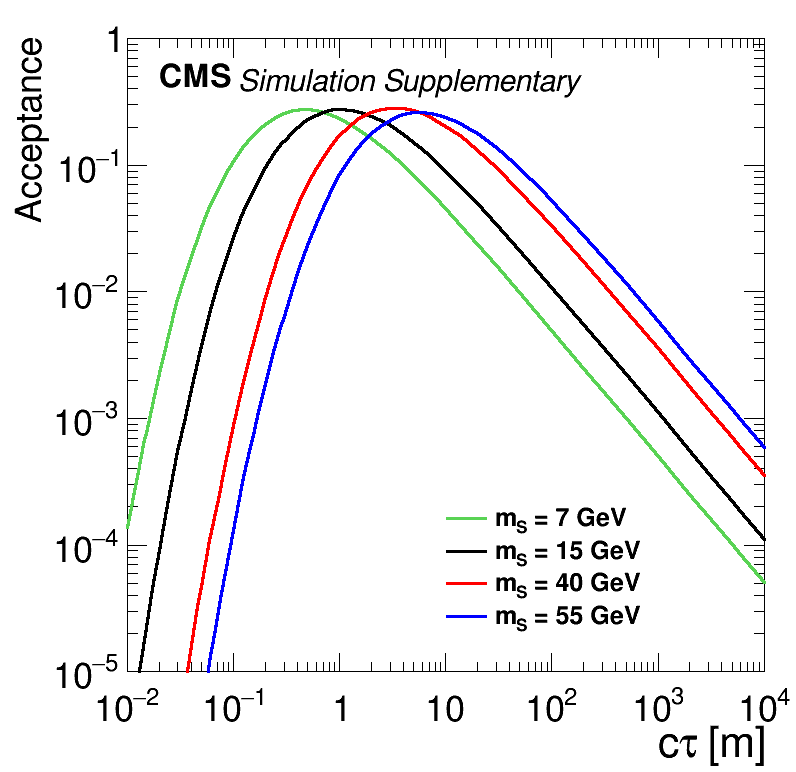

In [14]:
importlib.reload(sys.modules['CMS_lumi'])


leg = rt.TLegend(0.55,0.18,0.84,0.35)
# leg = rt.TLegend(0.7,0.75,0.84,0.9)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
for i,m in enumerate(h.keys()):
    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])
#     h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-5,1)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')


CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.05
CMS_lumi.relPosY = 0.041      
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 10)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


c.SaveAs(output_dir+'csc_acceptance.png')
c.SaveAs(output_dir+'csc_acceptance.C')
c.SaveAs(output_dir+'csc_acceptance.pdf')
c.Draw()



